# Intermediate Machine Learning

Poniższy notebook sporządzono na podstawie kursu dostępnego pod adresem https://www.kaggle.com/learn/intermediate-machine-learning. 

Tutorial pokazuje m.in.:

- jak pracować z danymi kategorycznymi (categorical values) i danymi brakującymi (missing values)
- jak poprawić jakość kodu
- jak używać zaawansowanych technik walidacji modelu (walidacja krzyżowa)
- jak budować modele z użyciem XGBoost
- jak unikać częstych błędów (data leakage)

Agenda:
1. **Introduction**
2. **Missing Values**
3. **Categorical Variables**
4. **Pipelines**
5. **Cross-Validation**
6. **XGBoost**
7. **Data Leakage**

## 1) INTRODUCTION
Poniższy tutorial działa w oparciu o zbiór danych dot. cen domów w 'Iowa' oraz algorytm Lasów Losowych

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# wczytanie danych (zbiór jest domyślnie podzielony na część treningową i testową)
X_full = pd.read_csv('./iowa_train.csv', index_col='Id')
X_test_full = pd.read_csv('./iowa_test.csv', index_col='Id')

# określenie cech i zmiennej przewidywanej
y = X_full['SalePrice']
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X_full[features].copy()
X_test = X_test_full[features].copy()

# podział domyślnego zbioru treningowego na zbiór treningowy właściwy (jego użyjemy do trenowania modelu) oraz 
# zbiór walidacyjny (poniżej: test_size)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [2]:
# podgląd danych, których użyjemy do wytrenowania modelu:
X_train.head()

,LotArea,YearBuilt,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd
Id,,,,,,,
619,11694,2007,1828,0,2,3,9
871,6600,1962,894,0,1,2,5
93,13360,1921,964,0,1,2,5
818,13265,2002,1689,0,2,3,7
303,13704,2001,1541,0,2,3,6


#### Ocena jakości modeli

In [3]:
from sklearn.ensemble import RandomForestRegressor

# definiujemy 5 różnych modeli Lasów Losowych
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

Parametry 'RandomForestRegressor':

- random_state - zapewnia powtarzalność wyników przy każdym uruchomieniu skryptu
- n_estimators - liczba drzew w lesie (domyślnie: 100)
- criterion - funkcja do pomiaru jakości podziału (opcje: 'mae', 'mse'; domyślnie: 'mse')
- max_depth - maksymalna "głębokość" drzewa (domyślnie: None)
- min_samples_split - minimalna liczba próbek wymagana do podziału węzła (domyślnie: 2)

W celu wybrania najlepszego z powyższych modeli zdefiniujemy poniżej funkcję 'score_model()'. Będzie ona zwracać wartość MAE dla zbioru walidacyjnego (tak jak poprzednio, patrz: Introduction_to_ML). Najlepszą wartością MAE dla zbioru walidacyjnego jest wartość najmniejsza!

In [4]:
from sklearn.metrics import mean_absolute_error

# definicja funkcji obliczającej MAE dla modelu:
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t) # trenujemy każdy model
    preds = model.predict(X_v) # wartości przewidywań dla zbioru walidacyjnego modelu
    return mean_absolute_error(y_v, preds) # wartość MAE dla modelu

models_mae = {}

# iterujemy po modelach:
for i in range(len(models)):
    mae = score_model(models[i])
    models_mae[models[i]] = mae
    print("Model %d MAE: %d" % (i+1, mae))

Model 1 MAE: 24015
Model 2 MAE: 23740
Model 3 MAE: 23528
Model 4 MAE: 23996
Model 5 MAE: 23706


In [5]:
# wybór najlepszego modelu z punktu widzenia wartości MAE:
min_mae = models_mae[model_1]
for k, v in models_mae.items():
    if v < min_mae:
        min_mae = v
        best_model = k # model_3

#### Predykcja

In [6]:
# definiujemy ostateczny model na podstawie powyższej oceny MAE
final_model = best_model

In [7]:
# Trenujemy model na pełnym (domyślnym) zestawie danych treningowych
final_model.fit(X, y)

# Generujemy prognozy dla domyślnego zbioru testowego
preds_test = final_model.predict(X_test)

In [8]:
# Zapisujemy wynik predykcji do pliku CSV
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('iowa_predictions.csv', index=False)

## 2) MISSING VALUES

Większość bibliotek ML (włącznie z scikit-learn) zwraca błąd przy próbie budowy modeli na danych, w których występują braki (NA). Poniżej poruszone zostaną 3 podejścia stosowane do pracy z brakującymi danymi.

#### Podejście 1: Usunięcie kolumn z brakującymi danymi

Najprostsze rozwiązanie (niekoniecznie najlepsze), to usunięcie kolumn, w których znajdują się braki danych.

<img src="Images/img_1.jpg">

Niestety, poprzez usuwanie całych kolumn znacznie zmniejsza się nasz zbiór danych pod kątem wyboru cech dla modelu (mamy mniej kolumn do wyboru przez co model może mieć później słabą jakość).

#### Podejście 2: Imputacja - przypisanie nowych wartości

Lepsze rozwiązanie niż usuwanie całych kolumn. Polega na zastąpieniu brakujących wartości np. średnią wartością dla danej kolumn

<img src="Images/img_2.jpg">

Wstawienie nowej wartości nie zawsze jest pożądane, ale zazwyczaj prowadzi do uzyskania modeli o wyższej jakości niż w przypadku usuwania całych kolumn.

W przypadku biblioteki Scikit-Learn możliwe jest zastosowanie metody 'SimpleImputer', która zastąpi braki danych (NaN) w danej kolumnie wartością średnią. Przykład:

In [9]:
#from sklearn.impute import SimpleImputer

## Wstawianie nowych wartości:
#imputer = SimpleImputer()
#imputed_X_train_data = pd.DataFrame(imputer.fit_transform(X_train_data))
#imputed_X_valid_data = pd.DataFrame(imputer.transform(X_valid_data))

## 'Imputacja' usuwa nazwy kolumn; należy wstawić je z powrotem:
#imputed_X_train_data.columns = X_train_data.columns
#imputed_X_valid_data.columns = X_valid_data.columns

#### Podejście 3: Imputacja + INFO - przypisanie nowych wartości oraz uwzgl. info o tym w nowej kolumnie

W tym podejściu zastępujemy braki danych, podobnie jak to miało miejsce w punkcie 2, ale oprócz tego dodajemy nową kolumnę  z informacją o tym czy dane w danym wierszu zostały zastąpione nową wartością, czy nie.

<img src="Images/img_3.jpg">

W pewnych przypadkach, model posiadając wiedzę nt tego, które wartości zostały zastąpione może uzyskiwać lepsze wyniki. W innych - nie zmieni to kompletnie niczego. Przykład:

In [10]:
## Tworzymy kopie danych, aby ich nie utracić (w razie czego):
#X_train_data_plus = X_train_data.copy()
#X_valid_data_plus = X_valid_data.copy()

## Tworzymy nowe kolumny z informacją (True lub False) czy dane zostały zmienione, czy nie:
#for col in cols_with_missing:
#    X_train_data_plus[col + '_was_missing'] = X_train_data_plus[col].isnull()
#    X_valid_data_plus[col + '_was_missing'] = X_valid_data_plus[col].isnull()

## 'Imputacja' - jak wyżej: ...

PODSUMOWANIE:

Podejścia 2 i 3 są lepsze w sytuacjach, gdy usuwając całe kolumny (podejście 1) usuwamy znaczną część danych, co może prowadzić do tego, że dane, które przekażemy do modelu będą niereprezentatywne i przez to model będzie miał słabą jakość. Z kolei, jeśli jakaś kolumna zawiera ponad 50% braków, to niewarto jej "na siłę" trzymać.

#### PRZYKŁAD
#### Zastosowanie powyższych podejść pracy z brakującymi danymi na zbiorze 'Iowa':

In [11]:
# wczytanie (ponowne) danych
X_full = pd.read_csv('./iowa_train.csv', index_col='Id')
X_test_full = pd.read_csv('./iowa_test.csv', index_col='Id')

# określenie cech i zmiennej przewidywanej oraz usunięcie wierszy, w których nie określono wartości przewidywanej (do 
# treningu takie dane są bezużyteczne)
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Dla uproszczenia do dalszej analizy użyjemy tylko cech o wartościach numerycznych
X = X_full.select_dtypes(exclude=['object'])
X_test = X_test_full.select_dtypes(exclude=['object'])

# podział domyślnego zbioru treningowego na zbiór treningowy właściwy i zbiór walidacyjny
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

##### 1. Wstępna ocena danych

In [12]:
# - wyświetlamy całkowitą ilość wierszy i kolumn (pomoże nam w oszacowaniu ilości brakujących danych)
print(X_train.shape)

# - liczba brakujących danych w każdej kolumnie zbioru treningowego:
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0]) # tylko kolumny gdzie ilość braków > 0

(1168, 36)
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


Wniosek:

Zgodnie z powyższym wynikiem mamy stosunkowo niewielką ilość braków danych (dla kolumny LotFrontage odsetek braków jest największy, ale i tak wynosi on < 20% wierszy), dlatego można przypuszczać, że całkowite usunięcie kolumn z brakami danych nie przyniesie dobrych wyników (wyrzucilibyśmy wiele cennych danych, dlatego prawdopodobnie 'imputancja' będzie lepszym rozwiązaniem).

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Definicja funkcji, która pozwoli porównać różne podejścia pracy z brakami danych
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

##### 2. Rozpatrujemy podejścia:

##### - Podejście 1 - usunięcie braków:

In [14]:
# kolumny z brakami danych:
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]

# modyfikacja (redukcja) danych - pozbycie się brakujących kolumn:
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

# wartość MAE dla zredukowanych danych:
print("MAE (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE (Drop columns with missing values):
17837.82570776256


##### - Podejście 2 - imputacja:

In [15]:
from sklearn.impute import SimpleImputer

# imputacja:
imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))

# 'Imputacja' usuwa nazwy kolumn; należy wstawić je z powrotem:
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

# wartość MAE dla zmodyfikowanych danych:
print("MAE (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE (Imputation):
18062.894611872147


WNIOSEK:

Wynik jest zaskakujący, ponieważ zakładaliśmy, że przy tak niewielkiej ilości brakujących danych imputacja zwróci lepszy wynik (mniejszą wartość MAE) niż całkowite usunięcie kolumn. Taki wynik może być spowodowany 'szumem' obecnym w danych. Ponadto, może się okazać, że imputacja, która wstawia średnią wartość nie jest odpowiednia dla tego zbioru danych i możliwe, że lepiej byłoby wstawiać w miejsce braków wartości 0 lub wartości najczęściej spotykanej w danej kolumnie itd. Za przykład niech posłuży kolumna 'GarageYrBlt, która wskazuje rok budowy garażu i w której wartość NaN oznacza po prostu brak garażu. 

##### 3. Predykcja (z zastosowaniem imputacji z parametrem)

In [16]:
# imputacja
final_imputer = SimpleImputer(strategy='median')
final_X_train = pd.DataFrame(final_imputer.fit_transform(X_train))
final_X_valid = pd.DataFrame(final_imputer.transform(X_valid))

# wstawienie nazw kolumn
final_X_train.columns = X_train.columns
final_X_valid.columns = X_valid.columns

In [17]:
# definiowanie i trening modelu
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(final_X_train, y_train)

# predykcja na zbiorze walidacyjnym i obliczenie wartości MAE
preds_valid = model.predict(final_X_valid)
print("MAE ('final' approach):")
print(mean_absolute_error(y_valid, preds_valid))

MAE ('final' approach):
17791.59899543379


In [18]:
# imputacja dla danych testowych:
final_X_test = pd.DataFrame(final_imputer.transform(X_test))

# predykcja na zbiorze testowym:
preds_test = model.predict(final_X_test)

In [19]:
# Zapisujemy wynik predykcji do pliku CSV
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('iowa_predictions_miss_vals.csv', index=False)

## 3) CATEGORICAL VARIABLES

Zmienne kategoryczne posiadają organiczoną liczbę wartości. Mogą to być np. odpowiedzi na pytanie ankietowe ("Nigdy", "Rzadko", "Często", "Codziennie") czy marki samochodów (Homda, Toyota, Ford). Ogólnie, są jasno określone i jest ich skończona ilość (jasno wskazują daną kategorię).

W Pythonie, jeśli zechcemy użyć zmiennych kategorycznych do budowy modelu ML w ich podstawowej formie, to dostaniemy błąd, dlatego należy poddać je "preprocessingowi" i **zamienić je na wartości liczbowe**. Wyróżnia się 3 podejścia pracy ze zmiennymi kategorycznymi

#### Podejście 1: Usunięcie zmiennych kategorycznych
Najłatwiejszym rozwiązaniem jest usunięcie zmiennych (kolumn) zawierających wartości kategoryczne. Działa tylko, jeśli kolumny nie zawierają informacji istotnych z punktu widzenia modelu.

#### Podejście 2: Label Encoding
Polega na przypisaniu etykietom wartości liczbowych (int). Jest to swego rodzaju porządkowanie etykiet, np. "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).

<img src="Images/img_4.jpg">

Powyższe podejście ma sens, ponieważ kategorie (etykiety) mają swój "ranking". Nie wszystkie zmienne kategoryczne mają jednak wartości, które da się uporządkować (inaczej, nie wszystkie zmienne kategoryczne działają, jak zmienne porządkowe!). W przypadku Drzew i Lasów można jednak zakładać, że kodowanie (jw) zmiennych porządkowych przyniesie dobry wynik.

WAŻNE!
Jeśli w kolumnie zbioru walidacyjnego występują dane kategoryczne, których wartości nie występują w tej samej kolumnie zbioru treningowego, to otrzymamy BŁĄD! Najprostszym rozwiązaniem w takiej sytuacji jest po prostu całkowite usunięcie problematycznej kolumny (podejście 1).

#### Podejście 3: One-Hot Encoding
Polega na utworzeniu nowego zestawu kolumn, który jasno określa czy dana wartość zmiennej kategorycznej występuje w zbiorze danych, czy nie.

<img src="Images/img_5.jpg">

One-Hot Encoding (w odróżnieniu do 'Podejścia 2') nie porządkuje kategorii, dlatego podejście to sprawdza się, gdy nie jest jasny porządek wartości zmiennej kategorycznej (np. "Red" nie jest ani większy ani zmiejszy od "Yellow") - zmienne kategorycznie nieposiadające "rankingu" są określane mianem **zmiennych nominalnych**.

Podejście One-Hot Encoding nie działa dobrze, jeśli zmienna kategoryczna przyjmuje zbyt wiele unikalnych wartości (zakłada się, że nie używa się tego podejścia jeśli unikalnych wartości > 15 - w celu sprawdzenia liczby unikalnych wartości:

DataFrame['Kolumna'].unique() ).

#### Przykład:
Zazwyczaj zmienne kategoryczne są reprezentowane przez kolumny zawierające wartości tekstowe (w pandas: 'object'). W celu określenia zmiennych kategorycznych:

In [20]:
## zwracamy listę zmiennych kategorycznych przy użyciu metody 'dtypes':
#s = (X_train.dtypes == 'object')
#object_cols = list(s[s].index)

##### - Podejście 1:

In [21]:
# drop_X_train = X_train.select_dtypes(exclude=['object'])
# drop_X_valid = X_valid.select_dtypes(exclude=['object'])

## Określamy wartość MAE po usunięciu zmiennych kategorycznych:
#print("MAE from Approach 1 (Drop categorical variables):")
#print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

##### - Podejście 2:

In [22]:
#from sklear.preprocessing import LabelEncoder

## Tworzymy kopię danych (w razie wu):
#label_X_train = X_train.copy()
#label_X_valid = X_valid.copy()

##### Aplikujemy metodę 'LabelEncoder' dla każdej kolumny zawierającej dane kategoryczne (określono wcześniej):
#label_encoder = LabelEncoder()
#for col in object_cols:
#    label_X_train[col] = label_encoder.fit_transform(X_train[col])
#    label_X_valid[col] = label_encoder.transform(X_valid[col])

## Określamy wartość MAE:
#print("MAE from Approach 2 (Label Encoding):") 
#print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

##### - Podejście 3:

W celu skorzystania z metody 'OneHotEncoder' modułu Scikit-Learn należy określić wartości m.in. poniższych parametrów:

- handle_unknown=ignore - pozwala uniknąć błędów, jeśli zbiór walidacyjny zawiera klasy, które nie występowały w zbiorze treningowym;
- sparse=False - zapewnia, że kolumny, które poddajemy "kodowaniu" będą miały format 'numpy array' zamiast 'sparse matrix'.

Stosując One-Hot Encoder używamy tylko kolumn zawierających dane kategoryczne, które chcemy poddać "kodowaniu".

In [23]:
#from sklearn.preprocessing import OneHotEncoder

## Aplikujemy OneHotEncoder dla danych kategorycznych:
#OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
#OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
#OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

## OneHotEncoder usuwa index; przywracamy go z powrotem:
#OH_cols_train.index = X_train.index
#OH_cols_valid.index = X_valid.index

## Usuwamy stare zmienne kategoryczne ze zbioru treningowego i walidacyjnego a w ich miejsce wstawiamy zmienne 
## kategoryczne powstałe w OneHotEncoder (patrz: PRZYKŁAD poniżej)
#num_X_train = X_train.drop(object_cols, axis=1)
#num_X_valid = X_valid.drop(object_cols, axis=1)

## Określamy wartość MAE:
#print("MAE from Approach 3 (One-Hot Encoding):") 
#print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

WNIOSEK:

Ostatecznie wybieramy podejście, dla którego wartość MAE jest najmniejsza. Zazwyczaj najlepsze wyniki (najmniejsze MAE) będą dla One-Hot Encoder (Podejście 3), a najgorsze - dla usunięcia kolumn (Podejście 1).

#### PRZYKŁAD
#### Zastosowanie powyższych podejść na zbiorze 'Iowa':

In [24]:
# wczytanie danych
X = pd.read_csv('./categorical_variables_dataset/train.csv', index_col='Id')
X_test = pd.read_csv('./categorical_variables_dataset/test.csv', index_col='Id')

# określenie cech i zmiennej przewidywanej oraz usunięcie wierszy, w których nie określono wartości przewidywanej (do 
# treningu takie dane są bezużyteczne)
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# Dla uproszczenia usuwamy kolumny zawierające braki danych:
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X.drop(cols_with_missing, axis=1, inplace=True)
X_test.drop(cols_with_missing, axis=1, inplace=True)

# podział domyślnego zbioru treningowego na zbiór treningowy właściwy i zbiór walidacyjny
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Definicja funkcji, która pozwoli porównać różne podejścia dla danych kategorycznych
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

##### 1. Rozpatrujemy podejścia:

##### - Podejście 1 - usunięcie danych kategorycznych:

In [26]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

# wartość MAE dla zredukowanych danych:
print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
17837.82570776256


##### - Podejście 2 - Label Encoding:

Przed zastosowaniem Label Encoding sprawdzimy dane, a dokładniej przyjrzymy się dokładniej kolumnie 'Condition2'

In [27]:
# Wyświetlamy unikalne wartości występujące w kolumnie 'Condition2' dla zb. treningowego i walidacyjnego
print("Unique values in 'Condition2' column in training data:", X_train['Condition2'].unique())
print("\nUnique values in 'Condition2' column in validation data:", X_valid['Condition2'].unique())

Unique values in 'Condition2' column in training data: ['Norm' 'PosA' 'Feedr' 'PosN' 'Artery' 'RRAe']

Unique values in 'Condition2' column in validation data: ['Norm' 'RRAn' 'RRNn' 'Artery' 'Feedr' 'PosN']


Komentarz:

Jak widać, unikalne wartości kolumny 'Condition2' dla zbioru treningowego i walidacyjnego różnią się, dlatego chcąc zastosować Podejście 2 musimy pozbyć się problematycznej kolumny 'Condition2'. Zgodnie z poniższym kodem, kolumny "problematyczne" przypisemy do zmiennej 'bad_label_cols', zaś kolumny dla których bez problemów możemy zastosować podejście Label Encoding zostaną zapisane w zmiennej 'good_label_encoding'.

In [28]:
# All categorical columns
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_train[col]) == set(X_valid[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be label encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'BldgType', 'HouseStyle', 'ExterQual', 'CentralAir', 'KitchenQual', 'PavedDrive', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Utilities', 'Heating', 'Exterior1st', 'LandSlope', 'Functional', 'HeatingQC', 'SaleType', 'Neighborhood', 'RoofStyle', 'ExterCond', 'Condition2', 'Foundation', 'Exterior2nd', 'RoofMatl', 'Condition1']


Poniżej usuwamy problematyczne kolumny, które nie nadają się dla Podejścia 2, a następnie stosujemy Label Encoding (Podejście 1) dla zbioru treningowego i walidacyjnego:

In [29]:
from sklearn.preprocessing import LabelEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply Label Encoder
label_encoder = LabelEncoder()
for col in set(good_label_cols):
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])

# wartość MAE dla zmodyfikowanych danych:   
print("MAE from Approach 2 (Label Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Label Encoding):
17575.291883561644


##### - Podejście 3 - One-Hot Encoding:
Zanim zastosujemy podejście O-HE należy sprawdzić liczebność poszczególnych kolumn z danymi kategorycznymi, ponieważ, jak wiadomo, podejście to nie działa dobrze, jeśli zmienna kategoryczna przyjmuje zbyt wiele unikalnych wartości.

In [30]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('PavedDrive', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('ExterQual', 4),
 ('KitchenQual', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

Powyżej jasno widać, ile unikalnych wartości zawierają poszczególne kolumny.

W przypadku wielkich zbiorów danych (wiele wierszy), podejście O-HE może dodatkowo znacząco go powiększyć (np. dla zbioru o liczbie wierszy 10 000 i kolumnie z danymi kategorycznymi zaw. 100 unikalnych wartości stosujęc O-HE powiększymy pierwotny zbiór o 10 000 * 100 - 10 000 wierszy!!!!!!). Z tego powodu powinno ono być używane tylko dla kolumn z relatywnie małą liczbą unikalnych wartości (< 15). Pozostałe kolumny (> 15) albo usuwamy całkowicie (podejście 1), albo stosujemy Label Encoding (podejście 2).


Dla przykładu zastosujemy podejście O-HE jedynie dla kolumn o liczbie unikalnych wartości < 10 ('low_cardinality_cols'):

In [31]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Neighborhood', 'Exterior1st', 'Exterior2nd']


Modyfikujemy zbiór treningowy i walidacyjny zgodnie z powyższym (tylko kolumny 'low_cardinality_cols') oraz obliczamy wartość MAE:

In [32]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# wartość MAE dla zmodyfikowanych danych:
print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):
17525.345719178084


## 4) PIPELINES

Potoki (ang. pipelines) służą do organizowania (w pewnym sensie porządkowania) naszego kodu, który służy nam do "preprocessingu" danych oraz definiowania modeli (Inaczej, potoki obejmują etapy wstępnego przetwarzania danych i modelowania, dzięki czemu jest to w pewnym sensie jeden krok). Oczywiście możliwe jest modelowanie bez używania potoków (jak wyżej), ale posiadają one jednak sporo zalet, np. dzięki ich stosowaniu mamy:

- czyściejszy kod
- mniej bugów
- łatwiejsze wprowadzenie kodu na produkcję
- więcej sposobów na walidację modelu (np. walidacja krzyżowa)

Przykładowo, przy użyciu potoków łatwo poradzić sobie zarówno z brakami danych, jak i z modyfikacją zmiennych kategorycznych. Potok składa się z 3 kroków:

#### Krok 1: Definiujemy etapy obróbki danych (preprocessing steps)

Stosując klasę 'ColumnTransformer' możemy "załatwić" różne etapy "preprocessingu" danych. Kod poniżej:

- "imputuje" (zastępuje) braki danych w zmiennych numerycznych
- "imputuje" (zastępuje) braki danych oraz aplikuje podejście O-HE dla zmiennych kategorycznych

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

## Preprocessing for numerical data:
#numerical_transformer = SimpleImputer(strategy='constant')

## Preprocessing for categorical data:
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

## Bundle preprocessing for numerical and categorical data (wszystko razem):
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', numerical_transformer, numerical_cols),
#        ('cat', categorical_transformer, categorical_cols)
#    ])

#### Krok 2: Definiujemy model
Poniżej, przykładowo, model Lasów Losowych

In [34]:
from sklearn.ensemble import RandomForestRegressor

#model = RandomForestRegressor(n_estimators=100, random_state=0)

#### Krok 3: Tworzymy potok i poddajemy ocenie wynik (evaluation)
Poniżej zastosujemy klasę 'Pipeline' do zdefiniowania naszego potoku, który "załatwi" nam preprocessing oraz tworzenie modelu. Istotne są:

- stosując potoki, dokonujemy obróbki danych treningowych oraz uczymy model w pojedynczej linii kodu (dla porównania, bez potoków chcąc poradzić sobie z brakami danych, zmodyfikować dane kategoryczne (np. O-HE) oraz wytrenować model musimy każdy z tych etapów przeprowadzić osobno)
- stosując potoki, przekazujemy nieobrobione cechy (dane) ze zbioru walidacyjnego (X_valid) bezpośrednio do metody 'predict()' i to właśnie potok automatycznie je obrabia zanim dokona prognoz (dla porównania, bez potoków musimy pamiętać, aby przed predykcją poddać obróbce również zbiór walidacyjny!)

In [35]:
from sklearn.metrics import mean_absolute_error

## Bundle preprocessing and modeling code in a pipeline
#my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                              ('model', model)
#                             ])

## Preprocessing of training data, fit (train) model 
#my_pipeline.fit(X_train, y_train)

## Preprocessing of validation data, get predictions
#preds = my_pipeline.predict(X_valid)

## Evaluate the model (get MAE)
#score = mean_absolute_error(y_valid, preds)
#print('MAE:', score)

WNIOSKI:

Potoki są wartościowe z punktu widzenia czystego kodu oraz unikania błędów. Przede wszystkim jednak warto je stosować przy skomplikowanej obróbce danych.

## 5) CROSS VALIDATION
Dotychczasowe podejście, czyli budowa modeli w w oparciu dane (ang. data driven) opierało się na dokonywaniu wyborów dotyczących tego, jakich zmiennych predykcyjnych użyć, jakich typów modeli użyć, jakich cech dostarczyć do tych modeli itp. Takie podejście ma jednak pewne wady. 

Jedną z nich jest choćby wyodrębnianie zbioru walidacyjnego ze zbioru treningowego. Ogólnie rzecz biorąc, im większy zbiór walidacyjny, tym jest mniej przypadkowości („szumu”) w naszej mierze jakości modelu i tym bardziej będzie ona wiarygodna. Niestety, duży zbiór walidacyjny możemy uzyskać tylko poprzez zabranie wierszy z naszego zbioru treningowego, a im mniejszy zbiór treningowy, tym gorszy model (błędne koło...).

W celu uniknięcia "zużywania" zbyt dużej ilości danych treningowych na zbiór walidacyjny możemy skorzystać z techniki zwanej **walidacją krzyżową (ang. cross validation)**, która polega na tym, że zbiór treningowy zostaje rozdzielony na uzupełniające się wzajemnie mniejsze podzbiory. Każdy model jest uczony za pomocą różnych kombinacji tych podzbiorów i oceniany przy użyciu pozostałych, nieużytych podzbiorów, co prowadzi do uzyskania wielu miar jakości modelu.

Przykładowo, możemy podzielić dane treningowe na 5 podzbiorów (ang. folds), czyli każdy to 20% całego zbioru treningowego:

<img src="Images/img_6.jpg">

Następnie, uruchamiamy jeden eksperyment dla każdego z nich:
* w eksperymencie 1 używamy pierwszego podzbioru, jako zbioru walidacyjnego, a wszystkich pozostałych używamy do trenowania modelu. To daje nam pomiar jakości modelu oparty na 20% początkowych danych treningowych.
* w eksperymencie 2 zbiorem walidacyjnym jest drugi podzbiór i z tego eksperymentu uzyskujemy drugą wartość określającą jakość naszego modelu
* powtarzamy ten proces do momentu, aż każdy z podzbiorów będzie użyty jako zbiór walidacyjny. Finalnie, 100% danych zostanie użyte do oceny jakości (jako zbiór walidacyjny) co oznacza, że otrzymamy miarę jakość opartą na wszystkich wierszach zestawu danych (nawet, jeśli nie używamy wszystkich wierszy jednocześnie!).

#### Kiedy używać walidacji krzyżowej?
Walidacja krzyżowa daje dokładniejszą miarę jakości modelu, co jest szczególnie ważne jeśli dokonujemy wiele decyzji jeszcze na etapie modelowania (?). Jest to jednak proces, który może trwać dość długo, ponieważ dokonuje on oceny wielu modeli (w powyższym przykładzie jeden model musi "przejść" przez dane 5 razy).

Kiedy zatem stosować walidację krzyżową?
* w przypadku małych zestawów danych, dla których przeprowadzenie dodatkowych obliczeń (jak wyżej) nie będzie wielkim problemem, ale już podejście "data driven" i wyodrębnianie zbioru walidacyjnego ze zbioru treningowego może znacząco wpłynąć na jakość modelu
* w przypadku większych zbiorów wystarczy natomiast jeden zestaw walidacyjny - kod będzie działał szybciej a danych będzie wystarczająco dużo i do treningu i do walidacji.

Nie istnieje prosty sposób na ocenę, co stanowi duży a co mały zbiór danych. Można przyjąć, że jeśli uruchomienie modelu zajmuje kilka minut lub mniej, to warto skorzystać z walidacji krzyżowej.

Można również przeprowadzić walidację krzyżową i sprawdzić czy wyniki dla każdego eksperymentu są do siebie zbliżone - jeśli wyniki różnią się nieznacznie lub są nawet identyczne, prawdopodobnie wystarczy jeden zestaw walidacyjny (podejście "data driven").

#### Przykład:
Stosowanie walidacji krzyżowej bez użycia potoków jest dość problematyczne, dlatego w poniższym przykładzie zastosowano właśnie potoki.

In [36]:
# USTAWIENIA

import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
train_data = pd.read_csv('./categorical_variables_dataset/train.csv', index_col='Id')
test_data = pd.read_csv('./categorical_variables_dataset/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = train_data.SalePrice              
train_data.drop(['SalePrice'], axis=1, inplace=True)

# Select numeric columns only
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
X = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()


from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', RandomForestRegressor(n_estimators=50, random_state=0))
])

Biblioteka Scikit-Learn zawiera walidację krzyżową pod nazwą 'cross_val_score', gdzie liczbę podzbiorów określa parametr 'cv'. Z kolei parametr 'scoring' określa miarę jakości modelu: w tym przypadku wybraliśmy **ujemny** błąd bezwzględny (negative MAE - dlaczego 'negative'? Konwencja Scikit-Learn).

Ponadto, jako że zazwyczaj miarą jakości jest pojedyncza liczba musimy wyciągnąć średnią (mean) spośród wszystkich wartości MAE (scores), jakie otrzymamy dla każdego eksperymentu.

In [37]:
from sklearn.model_selection import cross_val_score

# Całość zawarliśmy w pojedynczej funkcji, która zwraca średnią wartość MAE w zależności od ilości (n_estimators) drzew 
# w modelu Lasów Losowych:
def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    my_pipeline = Pipeline(steps=[
        ('preprocessor', SimpleImputer()),
        ('model', RandomForestRegressor(n_estimators, random_state=0))
    ])
    
    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(my_pipeline, X, y,
                                  cv=3,
                                  scoring='neg_mean_absolute_error')
    
    return scores.mean()

# Pętla dla różnych wartości 'n_estimators'
results = {}
for i in range(1,9):
    results[50*i] = get_score(50*i)

Oceny najlepszej wartości parametru 'n_estimators' dokonano na podstawie wykresu:

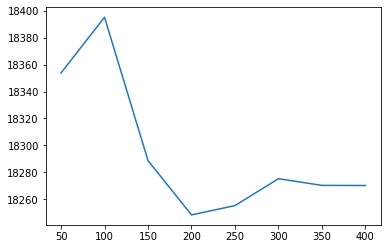

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [39]:
# Najlepsza wartość 'n_estimators' to taka wartość, dla której MAE jest najmniejsze!!! Zatem: 
n_estimators_best = min(results, key=results.get)
print(n_estimators_best)

200


PODSUMOWANIE:

Stosowanie walidacji krzyżowej daje dużo lepsze wyniki jeśli chodzi o pomiar jakości modelu. Warto zauważyć, że nie trzeba również (stosując walidację i potoki!) zwracać szczególnej uwagi osobno na zbiór treningowy i walidacyjny - zwłaszcza przy małych zbiorach jest to bardzo pomocne.

## 6) XGBoost

#### Metoda gradientowa

Metoda gradientowa (ang. gradient boosting) służy do budowy i optymalizacji modeli. Metoda ta dominuje w konkursach na kaggle.com i zapewnia najlepsze wyniki dla różnych zbiorów danych.

Gradient boosting to kolejny, po lasach losowych, przykład "metody zespołowej" (ang. ensemble method). Jej działanie opiera się na cyklach - kolejnych iteracjach, które dodają modele do "zespołu".

Na początku "zespół" zawiera jeden model, ktorego wyniki (prognozy) mogą być dość naiwne, jednakże kolejne iteracje uwzględniają popełnione błędy i dodają kolejne modele z "poprawkami".

Na jeden cykl metody składają się następujące kroki:
* w pierwszym kroku używamy bieżącego zespołu (może to być np. pojedynczy model) do generowania prognoz dla każdej obserwacji w zbiorze danych (jeśli modeli w zespole jest > 1, to dodajemy prognozy ze wszystkich modeli w tym zespole)
* następnie używamy "funkcji strat" (ang. loss function; np. takiej jak Minimum Square Error (MSE)), aby wprowadzić "poprawki" do modelu i następnie dodać go (ten poprawiony model) do "zespołu" - przede wszystkim określamy parametry modelu tak, by dodanie tego nowego (poprawionego) modelu do zespołu zmniejszyło straty, czyli zwiększyło jego jakość! (Komentarz: "gradient" w nazwie metody "gradient boosting" oznacza, że do określenia parametrów w tym nowym modelu użyjemy "metody gradientowej" (ang. gradient descent) w funkcji straty).
* na koniec dodajemy "poprawiony" model do zespołu (ang. ensemble) i...
* ... powtarzamy cały proces od nowa!

<img src="Images/img_7.jpg">

#### Biblioteka XGBoost

Biblioteka Scikit-Learn posiada implementację metody gradientowej, ale jest ona dosyć uboga, dlatego podczas stosowania metody gradientowej będziemy korzystać z biblioteki **XGBoost** (extreme gradient boosting). Jest to wiodąca biblioteka, jeśli chodzi o pracę z danymi tabelarycznymi (takimi, które można przechowywać w DataFrame w przeciwieństwie do danych takich jak obrazy czy video), która poprzez "tuning" parametrów pozwala wytrenować modele o wysokiej jakości.

**Ustawienia parametrów:**

Biblioteka XGBoost posiada kilka parametrów, które znacznie wpływają na jakość oraz szybkość trenowania danych. Są to m.in.:
- **n_estimators** - określa, ile razy należy przejść przez cykl modelowania opisany powyżej. Jest równy liczbie modeli, które włączamy do zespołu. Za niska wartość spowoduje 'underfitting', a kolei za wysoka - 'overfitting'. Typowe wartości mieszczą się w przedziale 100-1000, chociaż to zależy od parametru 'learning_rate' opisanego poniżej
- **early_stopping_rounds** - pozwala automatycznie określić optymalną wartość parametru 'n_estimators'. Powoduje zatrzymanie kolejnych iteracji, gdy jakość dla zbioru walidacyjnego przestaje rosnąć (nawet jeśli nie sprawdziliśmy wszystkich wartości 'n_estimators'). Najlepiej jest ustawić wysoką wartość 'n_estimators' oraz użyć parametru 'early_stopping_rounds' w celu znalezienia optymalnego momentu to zatrzymania iteracji. Najrozsądniejszym wyborem jest ustawić 'early_stopping_rounds' = 5 - w takim przypadku zostanie wykonanych jedynie 5 iteracji, które nie polepszają jakości modelu.
- **eval_set** - korzystając z parametru 'early_stopping_rounds' konieczne jest również odłożenie "na bok" danych niezbędnych do obliczenia jakości na zbiorze walidacyjnym, do tego celu służy właśnie parametr 'eval_set'.
- **learning_rate** - zamiast uzyskiwać prognozy po prostu sumując prognozy z każdego modelu składowego, możemy pomnożyć prognozy z każdego modelu przez niewielką liczbę znaną jako współczynnik uczenia (learning_rate) przed ich dodaniem. Oznacza to, że każde kolejne drzewo decyzyjne, które dodajemy do zespołu pomaga nam mniej. Możemy więc ustawić wyższą wartość parametru 'n_estimators' bez ryzyka przetrenowania. Ogólnie, mały współczynnik 'learning_rate' i duża wartość 'n_estimators' dadzą dokładniejsze modele XGBoost, chociaż trenowanie modelu zajmie więcej czasu (dzieje się tak ponieważ wykonuje on więcej iteracji). Domyślna wartość 'learning_rate' = 0.1.
- **n_jobs** - mając do czynienia z dużymi zbiorami danych, w przypadku których konieczne jest spędzenie dużej ilości czasu na trenowanie modeli, można użyć **"przetwarzania równoległego"**, aby proces budowy modeli był szybszy. Służy do tego parametr 'n_jobs', którego wartość zazwyczaj ustawia się równą liczbie rdzeni komputera. W przypadku małych zbiorów danych jest on jednak bezużyteczny.

#### Przykład:

Setup:

In [40]:
# USTAWIENIA

from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv('./categorical_variables_dataset/train.csv', index_col='Id')
X_test_full = pd.read_csv('./categorical_variables_dataset/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary (opcjonalne))
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

1. Budowa modelu za pomocą metody gradientowej z domyślnymi parametrami:

In [44]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Define the model (pozostawiamy póki co domyślne wartości parametrów)
my_model_1 = XGBRegressor(random_state=0)

# Fit the model
my_model_1.fit(X_train, y_train)

# Get predictions
predictions_1 = my_model_1.predict(X_valid)

# Calculate MAE
mae_1 = mean_absolute_error(predictions_1, y_valid)
print("Mean Absolute Error:" , mae_1)

Mean Absolute Error: 17662.736729452055


2. Ulepszenie modelu poprzez określenie parametrów metody gradientowej:

In [46]:
# Define the model (zmieniamy domyślne wartości parametrów 'n_estimators' i 'learning_rate')
my_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# Fit the model
my_model_2.fit(X_train, y_train)

# Get predictions
predictions_2 = my_model_2.predict(X_valid)

# Calculate MAE
mae_2 = mean_absolute_error(predictions_2, y_valid)
print("Mean Absolute Error:", mae_2)

Mean Absolute Error: 16688.691513270547


3. Pogorszenie modelu poprzez bezmyślne ustawienie parametrów metody gradientowej

Ten krok jest raczej ciekawostką i ma na celu pokazanie, jak nie "ustawiać" parametrów, gdyż zazwyczaj prowadzi to do poroszenia modelu (wzrost MAE w porównaniu do "domyślnego" kroku 1).

In [48]:
# Define the model
my_model_3 = XGBRegressor(n_estimators=1)

# Fit the model
my_model_3.fit(X_train, y_train)

# Get predictions
predictions_3 = my_model_3.predict(X_valid)

# Calculate MAE
mae_3 = mean_absolute_error(predictions_3, y_valid)
print("Mean Absolute Error:", mae_3)

Mean Absolute Error: 127895.0828807256


## 7) DATA LEAKAGE (super ważne!!!)

**Data leakage** (wyciek danych) potrafi zrujnować nasz model w subtelny sposób, dlatego bardzo ważne jest radzenie spobie z nim w odpowiedni sposób.

**Czym jest data leakage?**

Wyciek danych ma miejsce, gdy dane treningowe zawierają informację nt zmiennej przewidywanej (target), ale podobne dane nie są dostępne, gdy dochodzi do prognozowania na nowych danych. Prowadzi to do wysokiej jakości modelu na zbiorze treningowym (a możliwe, że na walidacyjnym również), ale model słabo sprawdza się po wprowadzeniu go na produkcję.

Innymi słowy, wyciek danych powoduje, że model wygląda w porządku (ma zadowalającą jakość) dopóki nie wprowadzimy go na produkcję (nie zaczniemy na jego podstawie podejmować decyzji) - wtedy staje się on bardzo niedokładny.

Istnieją dwa główne rodzaje data leakage:

- target leakage
- train-test contamination

**Target leakage**

Ma miejsce, gdy zmienne przewidujące (predyktory - cechy - kolumny) zawierają dane, które nie będą dostępne w momencie podejmowania decyzji (na produkcji). Ważne jest zatem, aby podczas doboru cech do trenowania modelu myśleć w sposób chronologiczny, tzn. czy dana cecha nie pojawia się po uzyskaniu konkretnej wartości zmiennej przewidywanej (target).

Przykład: wyobraźmy sobie, że chcemy przewidzieć, kto zachoruje na zapalenie płuc (pneumonia). Wycinek zbioru danych wygląda następująco:

<img src="Images/img_8.jpg">

_Ludzie biorą antybiotyk PO zachorowaniu, aby wyzdrowieć. Powyższe surowe dane (ang. raw data; przed jakąkolwiek obróbką) pokazują silną korelację pomiędzy kolumnami 'got_pneumonia' i 'took_antibiotic_medicine', pomimo faktu, że kolumna 'took_antibiotic_medicine' została dodana dopiero po zachorowaniu (nikt raczej prewencyjnie leków nie bierze) więc nie ma wpływu na naszą zmienną przewidywaną - TO JEST WŁAŚNIE **DATA LEAKAGE**!_

Nie uwzględniając powyższej uwagi i trenując model na danych zawierających kolumnę 'took_antibiotic_medicine' nasz model znalazłby wzorzec, że każda osoba, która nie brała leków nie zachorowała na zapalenie płuc (co jest prawdą, bo leki beirze się dopiero po zachorowaniu a nie przed) - w związku z tym otrzymamy dobrą jakość przewidywań zarówno dla zbioru treningowego, jak i walidacyjnego (jest on wyodrębniony przecież ze zbioru treningowego więc wzorzec ten również będzie obecny). Niestety model będzie bardzo niedokładny po wprowadzeniu go na produkcję, ponieważ zbiór, dla którego będziemy chcieli przewidzieć czy dana osoba zachoruje, czy nie nie będzie zawierał informacji nt. brania leków na zapalenie płuc (branie leków, to nie potencjalna przyczyna choroby!).

Wynika stąd, że chcąc uniknąć "target leakage" powinniśmy z naszego zbioru treningowego (i walidacyjnego) usunąć cechy, których wartości zostały wprowadzone PO uzyskaniu wartości dla naszej zmiennej przewidywanej (target).

<img src="Images/img_9.jpg">

**Train-Test Contamination**

Ma miejsce, gdy nieuważnie podchodzimy do zbioru treningowego i walidacyjnego. Chodzi o to, że zbiór walidacyjny ma być miarą tego, jak model radzi sobie z danymi, których wcześniej nie brał pod uwagę (nie widział ich wcześniej, są dla niego kompletnie nowe). Przez naszą nieuwagę możemy doprowadzić do tego, że zbiór walidacyjny będzie niestety zawierał dane, które nasz model już zna (część z nich była zawarta w zbiorze treningowym) - to jest właśnie "Train-Test Contamination".

Przykład: wyobraźmy sobie, że przeprowadzamy preprocessing danych (np. zastępujemy braki danych) przed wywołaniem "train_test_split" (przed podziałem danych treningowych na zbiór treningowy i testowy). Jaki jest efekt? Model może uzyskać dobre wyniki na zbiorze testowym, co daje duże zaufanie do niego, ale będzie działał słabo po wdrożeniu na produkcję, dlatego **najpierw "train_test_split" a dopiero później modyfikacja danych (nie mylić w ewentualnym "train_test_split" na zbiór treningowy właściwy i walidacyjny)!!!** (oprócz wyboru cech i usunięcia wierszy, gdzie 'target' nieznany - to należy wykonać wcześniej, bo na nic nie wpływa).

Używanie potoków nie dopuszcza do powstania problemu z "Train-Test Contamination".

#### Przykłady:

https://www.kaggle.com/alexisbcook/data-leakage

https://www.kaggle.com/maciejwilk/exercise-data-leakage/edit